In [1]:
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
%matplotlib inline
plt.rcParams['figure.figsize']=[15.0,12.0]
plt.rcParams['figure.facecolor']="w"

plt.rcParams['axes.linewidth']=2
plt.rcParams['xtick.major.size']=6
plt.rcParams['xtick.major.width']=2
plt.rcParams['xtick.minor.size']=4
plt.rcParams['xtick.minor.width']=2
plt.rcParams['ytick.major.size']=6
plt.rcParams['ytick.major.width']=2
plt.rcParams['ytick.minor.size']=4
plt.rcParams['ytick.minor.width']=2
plt.rcParams['xtick.labelsize']=16
plt.rcParams['ytick.labelsize']=16
plt.rcParams['axes.labelsize'] =24
plt.rcParams['legend.fontsize']= 24
plt.rcParams['legend.framealpha'] = 0.95
plt.rcParams['legend.handlelength']=2.0
plt.rcParams['figure.facecolor']="w"
plt.rcParams['xtick.direction']= 'in'
plt.rcParams['ytick.direction']= 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

In [2]:
import sys, os
sys.path.append("/home/pat/terliuk/software/DARWIN/DecayFitter/") 
from AnalyticCalculator import AnalyticCalculator
from BinnedFitter import BinnedFitter

In [3]:
bin_edges = np.linspace(2200, 2800, 31)
#bin_edges = np.linspace(2435, 2481, 2)
erange="[%d, %d] keV, %d bins"%(bin_edges[0], bin_edges[-1], len(bin_edges)-1)
ltime = 10.
loader = AnalyticCalculator(bin_edges, 
                         livetime=ltime,
                         fidMass  = 5.0
                         )
fitter = BinnedFitter(loader =loader )

In [4]:
inject_values = {"AXe136": 0.0, 
                 "Scale208Tl" : 2.339e+00,
                 "Scale214Bi" : 9.278e-02,
                 "Scale44Sc"  : 2.339e+00 / 100.,# currently rate of Sc44 is 0.01 of the scale of 208 Tl 
                 "Scale137Xe" : 1.42e-3, 
                 "Scale222Rn" : 3.14e-4,
                 "Scale8B"    : 2.36e-4, 
                 "T12_136Xe_2vbb" : 2.165}

def_fvals =   {"AXe136"     : [  0.0, False], 
               "Scale208Tl" : [ 2.5e+00, False], 
               "Scale214Bi" : [ 0.1, False],
               "Scale137Xe" : [ 1.5e-3, False],
               "Scale222Rn" : [ 3.0e-4, False],
               "Scale8B"    : [ 2.0e-4, False],#0.01
               "T12_136Xe_2vbb"    : [2.1, False],
}
stepsizes = {"AXe136": 0.1, 
                 "Scale208Tl" : 0.5,
                 "Scale214Bi" : 0.1,
                 "Scale137Xe" : 5e-4, 
                 "Scale222Rn" : 1e-4,
                 "Scale8B"    : 1e-4, 
                 "T12_136Xe_2vbb" : 0.2}
bounds = {"Scale137Xe" : (0.001*inject_values['Scale137Xe'],inject_values['Scale137Xe']*1000.), 
          "Scale222Rn" : (0.001*inject_values['Scale222Rn'], inject_values['Scale222Rn']*1000)}
fitpriors_default = {"Scale208Tl" : [inject_values["Scale208Tl"],  0.0292*inject_values["Scale208Tl"]],  # 0.2/6.85
             "Scale214Bi" : [inject_values["Scale214Bi"],   0.163*inject_values["Scale214Bi"]],  # 1.41 +- 0.23
             "Scale137Xe" : [inject_values["Scale137Xe"],  0.1197*inject_values["Scale137Xe"]], #0.17/1.42
             "Scale222Rn" : [inject_values["Scale222Rn"],  0.0162*inject_values["Scale222Rn"]], #0.05/3.09
             "Scale8B"    : [inject_values["Scale8B"],     0.2267*inject_values["Scale8B"]], #(0.76/2.36 + 0.31/2.36 )*0.5
             "T12_136Xe_2vbb" : [inject_values['T12_136Xe_2vbb'], 0.029*inject_values['T12_136Xe_2vbb']]
                        }


fitpriors_ideal = {"Scale208Tl" : [inject_values["Scale208Tl"],  1e-8*inject_values["Scale208Tl"]],  # 0.2/6.85
             "Scale214Bi" : [inject_values["Scale214Bi"],  1e-8*inject_values["Scale214Bi"]],  # 1.41 +- 0.23
             "Scale137Xe" : [inject_values["Scale137Xe"],  1e-8*inject_values["Scale137Xe"]], #0.17/1.42
             "Scale222Rn" : [inject_values["Scale222Rn"],  1e-8*inject_values["Scale222Rn"]], #0.05/3.09
             "Scale8B"    : [inject_values["Scale8B"],     1e-8*inject_values["Scale8B"]], #(0.76/2.36 + 0.31/2.36 )*0.5
             "T12_136Xe_2vbb" : [inject_values['T12_136Xe_2vbb'],1e-8*inject_values['T12_136Xe_2vbb']]
                        }

expectation_hist = loader.getBinnedExpectation(**inject_values)

In [5]:
Scan_AXe136  = np.linspace(0,1,101)
LLHs_real = np.nan*np.ones_like(Scan_AXe136)
LLHs_ideal = np.nan*np.ones_like(Scan_AXe136)

global_ideal = fitter.FitValue(histogram = expectation_hist, 
               fitvalues = def_fvals, 
               priors = fitpriors_ideal,
               bounds=bounds, 
               errors = stepsizes, 
               ftol = 0.001,
               verbosity = 0
               )
global_real = fitter.FitValue(histogram = expectation_hist, 
               fitvalues = def_fvals, 
               priors = fitpriors_default,
               bounds=bounds, 
               errors = stepsizes, 
               ftol = 0.001,
               verbosity = 0
               )

for i in range(len(Scan_AXe136)):
    cur_fsettings = deepcopy(def_fvals)
    cur_fsettings["AXe136"] = [Scan_AXe136[i], True]
    fitres_ideal = fitter.FitValue(histogram = expectation_hist, 
               fitvalues = cur_fsettings, 
               priors = fitpriors_ideal,
               bounds=bounds, 
               errors = stepsizes, 
               ftol = 0.001,
               verbosity = 0
               )
    LLHs_ideal[i] = fitres_ideal['LLH']
    
    fitres_feal = fitter.FitValue(histogram = expectation_hist, 
               fitvalues = cur_fsettings, 
               priors = fitpriors_default,
               bounds=bounds, 
               errors = stepsizes, 
               ftol = 0.001,
               verbosity = 0
               )
    LLHs_real[i] = fitres_feal['LLH']    

WARNING! Minimizer failed for given tolerance.. trying to perturb the seed
WARNING! Minimizer failed for given tolerance.. trying to perturb the seed
WARNING! Minimizer failed for given tolerance.. trying to perturb the seed
WARNING! Minimizer failed for given tolerance.. trying to perturb the seed
There were warnings during the fit, here are the results
AXe136               0.19
Scale208Tl           2.3443710222095016
Scale214Bi           0.004128298005651843
Scale137Xe           0.0006848382480516947
Scale222Rn           0.00025397562532798105
Scale8B              0.0008183187683301618
T12_136Xe_2vbb       2.124476033981631
valid                True
LLH                  -2657.5734087383216
------------------------------------------------------------
WARNING! Minimizer failed for given tolerance.. trying to perturb the seed
There were warnings during the fit, here are the results
AXe136               0.31
Scale208Tl           2.350221578088912
Scale214Bi           1.655964543267885e-0

Text(0.5, 0.95, 'Energies : [2200, 2800] keV, 30 bins')

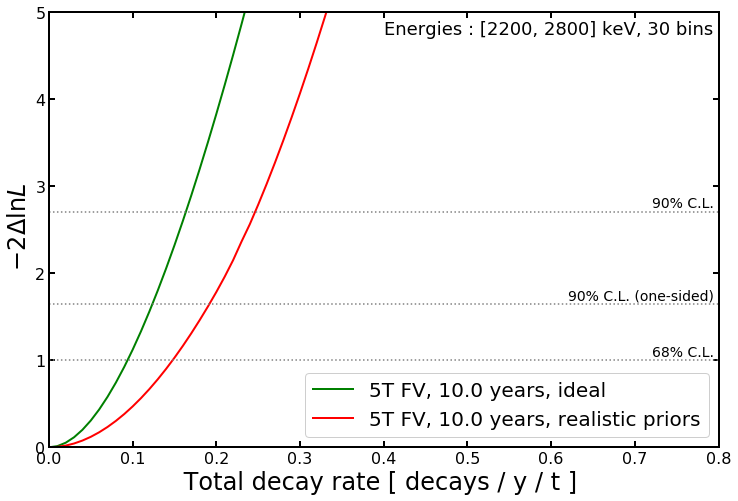

In [6]:
# And plotting the scan 
fig = plt.figure(figsize = (12,8))
ax= fig.add_subplot(111)
ax.plot(Scan_AXe136 , 2.0 * (LLHs_ideal  - global_ideal['LLH']), lw=2, c = "g", label = "5T FV, %0.1f years, ideal"%ltime )
ax.plot(Scan_AXe136 , 2.0 * (LLHs_real  - global_real['LLH']), lw=2, c = "r", label = "5T FV, %0.1f years, realistic priors"%ltime )

plt.axhline(1.0, c= "0.5", ls =":")
plt.axhline(2.71, c= "0.5", ls =":")

#ax.set_xscale("log")
ax.set_ylim(0, 5)
ax.set_xlim(0, 0.8)
ax.set_ylabel(r" $ - 2 \Delta \ln L $")
ax.set_xlabel(r" Total decay rate [ decays / y / t ]  ")
ax.legend(fontsize=20)
ax.text(0.72, 1.05, "68% C.L. ", fontsize=14)
ax.text(0.72, 2.76, "90% C.L. ", fontsize=14)
plt.axhline(1.643, c= "0.5", ls =":")
ax.text(0.62, 1.694, "90% C.L. (one-sided)", fontsize=14)
ax.text(0.50,0.95, "Energies : "+erange, transform=ax.transAxes, fontsize=18)


/misc/home/pat/terliuk/test_venv/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


Text(0.5, 0.75, 'Energies : [2200, 2800] keV, 30 bins')

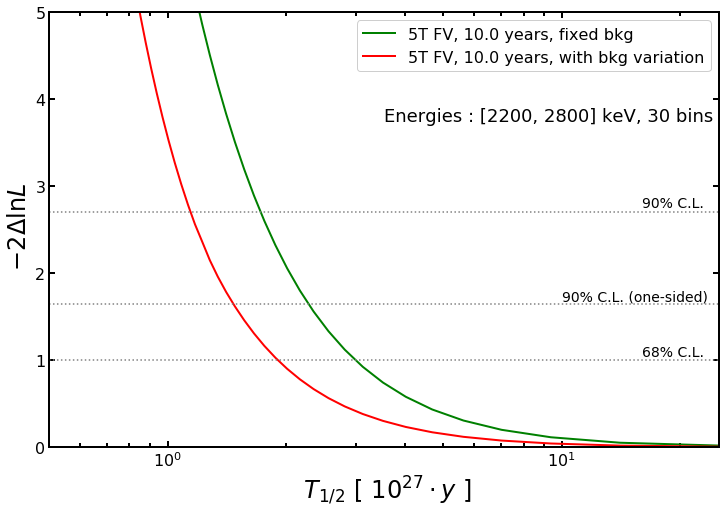

In [7]:
# we can also plot it as a function of half life 
# For this, we need to convert it using the formula 
# T_{1/2} = ln(2) / A * abundance * N_A / M_Xe
# With numbers plugged in 
# np.log(2)*6.0214/131.293*8.8573 = 0.28157 
# T_{1/2} [10^{27} y ] \approx  0.28157 / A [ ev / y / t ] 
T_1_2 = 0.28157 / Scan_AXe136


fig = plt.figure(figsize = (12,8), facecolor="w")
ax= fig.add_subplot(111)
ax.plot(T_1_2 , 2.0 * (LLHs_ideal  - global_ideal['LLH']), lw=2, c = "g", label = "5T FV, %0.1f years, fixed bkg"%ltime )
ax.plot(T_1_2 , 2.0 * (LLHs_real  - global_real['LLH']), lw=2, c = "r", label = "5T FV, %0.1f years, with bkg variation"%ltime )
for key in []:#LLHs.keys():
    #if key in ['real', 'ideal']: continue
    if "fix" not in key: continue
    ax.plot(T_1_2 , 2.0 * (LLHs[key]  - globalfits[key]['LLH']), 
            lw=2, ls="--", label = key )

plt.axhline(1.0, c= "0.5", ls =":")
ax.text(16.0, 1.05, "68% C.L. ", fontsize=14)

plt.axhline(1.643, c= "0.5", ls =":")
ax.text(10.0, 1.69, "90% C.L. (one-sided)", fontsize=14)

plt.axhline(2.71, c= "0.5", ls =":")
ax.text(16.0, 2.76, "90% C.L. ", fontsize=14)
ax.legend(fontsize=16)

ax.set_xscale("log")
ax.set_ylim(0, 5)
ax.set_xlim(0.5, 25)
ax.set_ylabel(r" $ - 2 \Delta \ln L $")
ax.set_xlabel(r" $T_{1/2}\ [\ 10^{27} \cdot y\ ] $")
ax.text(0.50,0.75, "Energies : "+erange, transform=ax.transAxes, fontsize=18)

In [8]:
from scipy.interpolate import interp1d
from scipy.optimize import root

critical_value = 1.643 
doubleLLH_profile_ideal = interp1d(T_1_2[1:], 2.0 * (LLHs_ideal  - global_ideal['LLH'])[1:], kind="cubic") 
halflife_result_ideal =  root(lambda x: doubleLLH_profile_ideal(x) - critical_value, 1.0 ) 
print("---- IDEAL BACKGROUND KNOWLEDGE ----")
print("Sensitivity :\t %0.3f 10^27 years"%halflife_result_ideal['x'][0])


doubleLLH_profile_real = interp1d(T_1_2[1:], 2.0 * (LLHs_real  - global_real['LLH'])[1:], kind="cubic") 
halflife_result_real =  root(lambda x: doubleLLH_profile_real(x) - critical_value, 1.0 ) 
print("---- REALISTIC BACKGROUND KNOWLEDGE ----")
print("Sensitivity :\t %0.3f 10^27 years"%halflife_result_real['x'][0])

---- IDEAL BACKGROUND KNOWLEDGE ----
Sensitivity :	 2.281 10^27 years
---- REALISTIC BACKGROUND KNOWLEDGE ----
Sensitivity :	 1.471 10^27 years
